# Assignment 10: X-Ray Pneumonia Detection

In this assignment, you are tasked with developing your own classifier for pneumonia in X-ray images. You will go through to the complete ML development cycle from loading and preprocessing your data to evaluating your models.

Download and extract the X-Ray dataset from Ilias to the same directory as your Jupyter notebook. The data is already split into a training, validation, and testing set. The dataset originates from the paper [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5).

You may use any packages, we encountered during the exercises (numpy, matplotlib, scikit-learn, scikit-image, pandas, pytorch) as well as the Python standard library.

You should (at least) address the following points in your development process:

- The dataset is imbalanced. Do at least one of the following:
    - Augment your dataset by including rotated, flipped, or brightened images. This will also improve the generalization capabilities of your model.
    - or: Modify your objective function by weighting the classes differently.
- Optimize the hyperparameters of your models using grid-search or random-search on the validation set.
- Consider at least two classes of models, e.g. CNN and SVM. At least one of your model classes should be some type of neural network implemented in PyTorch.
- After the hyperparameter optimization, select the best-performing models of each class. Evaluate these models on the testing data and visualize your results.


*Note*: You have 2 weeks to complete this assignment. The assignment is optional for B.Sc.Data Science students, who have an alternative easier assignment 10 on clustering. If you already have successfully submitted 7 assignments, you do not need to submit this assignment.
Presenting this assignment in a video counts as **2 video presentations**. Please indicate if you wish to present at the top of the notebook.

- *Put your names here*

**Indicate here whether you want to present.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.io
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import sklearn
import os
import torchvision
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score


In [2]:
# make data loader in this cell
# print(os.listdir(os.path.join('chest_xray/train','NORMAL')))
def load_data(directory):
    print("load images:")
    label=[]
    normal_images=[]
    pneumonia_images=[]
    # subFolder= ['NORMAL','PNEUMONIA']
    # for d in subFolder:
    directories=[d for d in os.listdir(os.path.join(directory,'NORMAL'))]
    for f in tqdm(directories,position=0):
        I=skimage.io.imread(os.path.join(os.path.join(directory,'NORMAL'),f))
        if len(I.shape) ==2:
            I=skimage.color.gray2rgb(I)
        normal_images.append(skimage.transform.resize(I,(128,128)))
        label.append(0)
    directories=[d for d in os.listdir(os.path.join(directory,'PNEUMONIA'))]
    for f in tqdm(directories,position=0):
        I=skimage.io.imread(os.path.join(os.path.join(directory,'PNEUMONIA'),f))
        if len(I.shape)==2:
            I=skimage.color.gray2rgb(I)
        pneumonia_images.append(skimage.transform.resize(I,(128,128)))
        label.append(1)

    # random rotate the image and blance the dataset
    anglelist=[90,270,180]

    if len(normal_images)<len(pneumonia_images):
        image_num_diff=len(pneumonia_images)-len(normal_images)
        for i in tqdm(range(image_num_diff)):
            idx=random.randint(0,len(normal_images)-1)
            angle_idx=random.randint(0,2)
            # angle=random.randint(-90,90)
            normal_images.append(skimage.transform.rotate(normal_images[idx],anglelist[angle_idx] ))
            label.append(0)
    elif len(normal_images)>len(pneumonia_images):
        image_num_diff=-len(pneumonia_images)+len(normal_images)
        for i in range(image_num_diff):
            idx=random.randint(0,len(pneumonia_images-1))
            angle_idx=random.randint(0,2)
            # angle=random.randint(-90,90)
            pneumonia_images.append(skimage.transform.rotate(pneumonia_images[idx],anglelist[angle_idx]) )
            label.append(1)
    
    images=normal_images+pneumonia_images
    images,label=np.array(images),np.array(label)
    return images,label


X_train,y_train= load_data('chest_xray/train')
X_val,y_val,=load_data('chest_xray/val')
X_test,y_test=load_data('chest_xray/test')


    
            

load images:
100%|██████████| 2534/2534 [00:07<00:00, 355.20it/s]
load images:
100%|██████████| 8/8 [00:00<00:00, 16.71it/s]
load images:
100%|██████████| 156/156 [00:00<00:00, 329.97it/s]


In [3]:
# test the dataset and define dateloader
# augument the dataset
device=torch.device('cuda')
print(X_train[0].shape)
class BasicDataset(object):
    def __init__(self, X, y,transform):
        self.X = np.moveaxis(X,-1,1)
        self.y = y
        self.transform=transform
    
    def __getitem__(self, idx):
        return dict(X=self.transform(torch.Tensor(self.X[idx])).numpy(), y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


(128, 128, 3)


In [4]:
# define the nn by pytorch
# 2 cnn layers with a shortcut layer then a dense layer 
#  refernce https://www.nature.com/articles/s41598-019-42557-4
class RNNClassifer(nn.Module):
    def __init__(self,hidden_size):
        super(RNNClassifer,self).__init__()
        self.cnnLayer1=nn.Sequential(
            nn.Conv2d(3,16,3,2,padding=2),
            nn.ReLU(),
            nn.Conv2d(16,16,3,2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.cnnLayer2=nn.Sequential(
            nn.Conv2d(16,32,3,1,padding=2),
            nn.ReLU(),
            nn.Conv2d(32,32,3,1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # self.cnnLayer3=nn.Sequential(
        #     nn.Conv2d(32,48,3,1,padding=2),
        #     nn.ReLU(),
        #     nn.Conv2d(48,48,3,1),
        #     nn.ReLU()
        # )

        self.shortcut_cnn1=nn.Sequential(
            nn.Conv2d(3,16,1,4),
            nn.ReLU()
        )
        self.shortcut_cnn2=nn.Sequential(
            nn.Conv2d(16,32,1,1),
            nn.ReLU()
        )
        # self.shortcut_cnn3=nn.Sequential(
        #     nn.Conv2d(32,48,1,1),
        #     nn.ReLU()
        # )
        self.poollayer=nn.MaxPool2d(3,2)
        self.gaplayeer=nn.AvgPool2d(3,2)
        self.dense_layer=nn.Sequential(
            nn.Linear(32*7*7,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.Dropout(0.3),
            nn.ReLU(),
            # nn.Linear(hidden_size,hidden_size),
            # nn.ReLU()
        )
        self.output_layer=nn.Linear(hidden_size,2)
    def forward(self,X):
        cnn_out=self.cnnLayer1(X)
        shortcut_out=self.shortcut_cnn1(X)

        out=self.poollayer(cnn_out+shortcut_out)

        cnn_out=self.cnnLayer2(out)
        shortcut_out=self.shortcut_cnn2(out)
        out=self.poollayer(cnn_out+shortcut_out)

        # cnn_out=self.cnnLayer3(out)
        # shortcut_out=self.shortcut_cnn3(out)
        # out=self.poollayer(cnn_out+shortcut_out)

        # out=self.gaplayeer(out)

        # print(out.shape)
        out=out.view(-1,32*7*7)
        out=self.dense_layer(out)
        out=self.output_layer(out)
        return out
        

# train the model
def train_model(model,dataset,learing_rate,batch_size,epochs):
    optimizer=optim.Adam(model.parameters(),lr=learing_rate)
    loss_list=[]
    acc_list=[]
    for epoch in range(epochs):
        data_loader=data.DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,drop_last=True)
        epoch_loss=0.0
        for batch in tqdm(data_loader,position=0):
            model.zero_grad()
            model.zero_grad()

            yhat=model.forward(batch['X'].float().to(device))

            batch_loss=F.cross_entropy(yhat,batch['y'].long().to(device))

            epoch_loss+=batch_loss.item()

            batch_loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')
        loss_list.append(epoch_loss)
        acc_list.append(evaluate_model(model,test_dataset))
    return acc_list,loss_list

# eval the model by accuraccy
def evaluate_model(model, dataset_val):
    with torch.no_grad():
        X=torch.from_numpy(np.array([sample['X'] for sample in dataset_val])).float()
        yhat_unnormalized=model.forward(X.to(device)).cpu().detach().numpy()
    
    yhat=np.argmax(yhat_unnormalized, axis=1)
    y=np.array([sample['y'] for sample in dataset_val])
    acc=accuracy_score(yhat,y)
    # print(yhat_unnormalized)

    print(" acc is",acc)
    return acc



In [5]:
# make the datset with transform 
transform_set={'train':torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    # torchvision.transforms.Normalize(mean=0,std=0.1),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
]),
        'test':torchvision.transforms.Compose([])}

train_dataset=BasicDataset(X_train,y_train,transform_set['train'])
val_dataset=BasicDataset(X_val,y_val,transform_set['test'])
test_dataset=BasicDataset(X_test,y_test,transform_set['test'])
epochs=20
MAX_EVALS=30

In [6]:
# make a hyperparameter set
param_grid={
    'learning_rate':list(np.logspace(np.log10(0.005),np.log10(0.5),base=10,num=1000)),
    'batch_size':[16,32,64,128,256],
    'hidden_size':[64,128,256,512,1024]
    }


best_acc=0
best_hypterparameter={}
torch.cuda.empty_cache()
# train the model with differents hyperparameter,and save the best modul and hypeparameter

for i in range(MAX_EVALS):
    hypterparameter={k:random.sample(v,1)[0] for k,v in param_grid.items()}

    lr=hypterparameter['learning_rate']
    batch_size=hypterparameter['batch_size']
    hidden_size=hypterparameter['hidden_size']

    model=RNNClassifer(hidden_size).to(device=device)
    model.train()
    train_model(model,train_dataset,lr,batch_size,epochs)
    model.eval()
    acc=evaluate_model(model,test_dataset)
    if acc>best_acc and acc!=0.5:
        best_hypterparameter=hypterparameter
        best_acc=acc
        torch.save(model.state_dict(),"best_sol.pt")
    torch.cuda.empty_cache()
print("best situation Hyperparameter :")
print(best_hypterparameter)
# 



79444089531898
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.34it/s]
Epoch 3/200 - Loss: 84.12902402877808
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.25it/s]
Epoch 4/200 - Loss: 83.9255940914154
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.21it/s]
Epoch 5/200 - Loss: 84.02575951814651
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.19it/s]
Epoch 6/200 - Loss: 83.88932180404663
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.39it/s]
Epoch 7/200 - Loss: 84.00524115562439
 acc is0.5
100%|██████████| 121/121 [00:09<00:00, 12.26it/s]
Epoch 8/200 - Loss: 83.93013978004456
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.10it/s]
Epoch 9/200 - Loss: 83.96688210964203
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.26it/s]
Epoch 10/200 - Loss: 83.97765588760376
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.40it/s]
Epoch 11/200 - Loss: 84.00688630342484
 acc is0.5
100%|██████████| 121/121 [00:08<00:00, 14.39it/s]
Epoch 12/200 - Loss: 84.03276026

In [21]:
# train the modul with latge epoches
print(best_hypterparameter)

loss_list=[]
acc_list=[]

best_model=RNNClassifer(best_hypterparameter['hidden_size']).to(device)
best_model.load_state_dict(torch.load("best_sol.pt"))
best_model.train()
acc_list,loss_list=train_model(best_model,train_dataset,0.01,256,100) 
best_model.eval()
acc=evaluate_model(best_model,test_dataset)
print("____________________________________")
print("The final accuracy is:",acc)
print("____________________________________")


{'learning_rate': 0.022264792549713273, 'batch_size': 64, 'hidden_size': 512}
100%|██████████| 30/30 [00:05<00:00,  5.52it/s]
Epoch 1/100 - Loss: 13.160492032766342
 acc is0.6807692307692308
100%|██████████| 30/30 [00:05<00:00,  5.57it/s]
Epoch 2/100 - Loss: 12.979227215051651
 acc is0.6820512820512821
100%|██████████| 30/30 [00:05<00:00,  5.67it/s]
Epoch 3/100 - Loss: 13.375810950994492
 acc is0.6833333333333333
100%|██████████| 30/30 [00:05<00:00,  5.96it/s]
Epoch 4/100 - Loss: 13.108968615531921
 acc is0.6782051282051282
100%|██████████| 30/30 [00:05<00:00,  5.81it/s]
Epoch 5/100 - Loss: 12.984515279531479
 acc is0.6782051282051282
100%|██████████| 30/30 [00:05<00:00,  5.76it/s]
Epoch 6/100 - Loss: 12.78470915555954
 acc is0.6717948717948717
100%|██████████| 30/30 [00:05<00:00,  5.79it/s]
Epoch 7/100 - Loss: 12.93576529622078
 acc is0.6820512820512821
100%|██████████| 30/30 [00:05<00:00,  5.52it/s]
Epoch 8/100 - Loss: 12.866144746541977
 acc is0.6897435897435897
100%|██████████| 30/

{'learning_rate': 0.00781923379151123, 'batch_size': 32, 'hidden_size': 64}


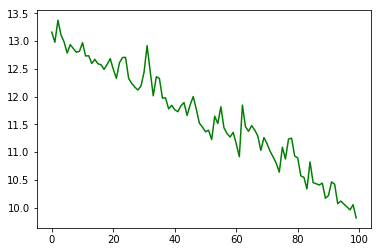

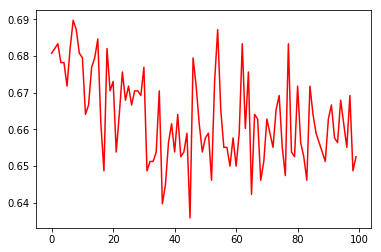

In [23]:
# plot the accc rate and loss
x_label=range(0,100)
print(hypterparameter)
plt.plot(x_label,loss_list,color='green')
plt.show()
plt.plot(x_label,acc_list,color='red')
plt.show()

In [ ]:
# in the uper blocks i tryed to use rnn to classifition and solve the problem, but i try to change the model, data argumentation, and also read the methode fgrom papers. but the accuracy is still round 70%.
#  in the under blocks i use SVM with gaussian kernel to solve the problem. and by sklearn

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
svcclassfer=SVC(kernel='rbf')
# X_train.tolist()
# y_train.tolist()

In [13]:
print(X_train[0].shape)
def trans_dataset_gray(data):
    res=[]
    trans=torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor()
        ])
    for iter in tqdm(data):
        temp=trans(torch.Tensor(iter)).numpy()
        
        res.append(np.array(temp.flatten()))
    return res
X_train_SVM=trans_dataset_gray(X_train)

(128, 128, 3)
100%|██████████| 7750/7750 [00:05<00:00, 1363.76it/s]


In [14]:
print(X_train_SVM[0].shape)
svcclassfer.fit(X_train_SVM,y_train)
X_test_SVM=trans_dataset_gray(X_test)
acc=accuracy_score(svcclassfer.predict(X_test_SVM),y_test)
print(acc)
classification_report(svcclassfer.predict(X_test_SVM),y_test)

(384,)
100%|██████████| 780/780 [00:00<00:00, 1332.45it/s]
0.6410256410256411


'             precision    recall  f1-score   support\n\n          0       0.97      0.58      0.73       650\n          1       0.31      0.92      0.46       130\n\navg / total       0.86      0.64      0.69       780\n'